# **SMS SPAM CLASSIFICATION**
---
---

---
# **Table of Content**

**1.** [**Problem Description**](#Section1)<br>
**2.** [**Installing & Importing Libraries**](#Section2)<br>
**3.** [**Data Description & Preprocessing**](#Section3)<br>
  - **3.1** [**Data Description**](#Section3.1)<br>
  - **3.2** [**Preprocessing**](#Section3.2)<br>

**4.** [**Model Building**](#Section4)<br>
  - **4.1** [**Simple RNN Model**](#Section4.1)<br>
  - **4.2** [**LSTM Model**](#Section4.2)<br>
  - **4.3** [**GRU Model**](#Section4.3)<br>

**5.** [**Impliment Train Model on Test Dataset**](#Section5)<br>


---




---

<a name = Section1></a>
# **1. Problem Description**
---

**The Scamer Club dataset**

 - We will work with the **Scamer Club** dataset, **Scammer Club** is a cyber-consulting company. They ensure the best cyber security consulting experience for their consumers.

 - Nowadays they are receiving a ton of requests and complaints regarding SMS spamming Many of the consumers have complained that they have faced severe financial issues because of this.

 - The company is going through a tough time dealing with the current spamming issue and at any cost, they want to deliver a high-quality consumer experience to its customers, Hence, they are willing to build an SMS Spam classification system that can tell if an SMS should be marked spammed or not.
 
 - For this reason, they want to depend on AI as they want high accuracy which is not practically possible for a human to deliver, Hence, they have outsourced this project to you as a Freelance NLP Engineer and they expect us to deliver this project with the best model possible.


---
<a name = Section2></a>
# **2. Installing & Importing Libraries**
---

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import string
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, GRU, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from collections import Counter

---
<a name = Section3></a>
# **3. Data Description & Preprocessing**


<a name = Section3.1></a>
# **3.1 Data Description**

- We Will work on SMS Dataset Which we have recived from the client: A set of **5,572** messages, They’re split into **4457 messages for training** and **1115 messages for testing**.

- Description of Dataset is mentioned below:-

|Column Name	|Description|
|-------------|:-----------|
|Id	|Unique identifier of the SMS|
|text	|Text in the SMS|
|label	|If the text is labelled as spam or not|

- The size of the Train and Test Dataset:-

|Train Data|Test Data|
|-------|-----|
|(4457,3)|(1152,2)|


In [ ]:
df=pd.read_excel('/content/spam_train.csv.xlsx')
print(df.shape)
print(df.head())

(4457, 3)
     Id                                               text label
0  1978  No I'm in the same boat. Still here at my moms...   ham
1  3989  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...  spam
2  3935     They r giving a second chance to rahul dengra.   ham
3  4078     O i played smash bros  &lt;#&gt;  religiously.   ham
4  4086  PRIVATE! Your 2003 Account Statement for 07973...  spam


- Checking the count of Spam and Ham in label column 

<Axes: >

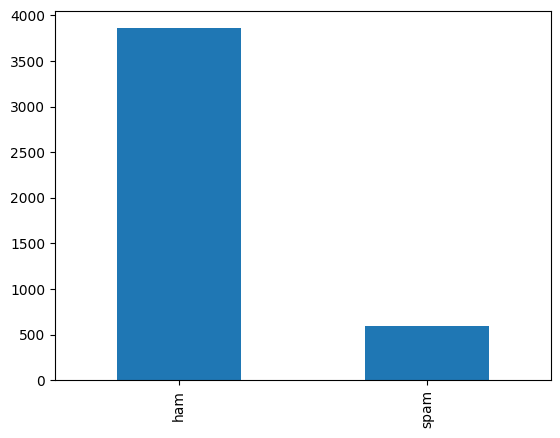

In [ ]:
df.label.value_counts().plot.bar()

- Count of the Ham is much greater than the Spam, So we need to normalized the data for better accuracy


<a name=Section3.2></a>
# **3.2 Data Preprocessing**


In [ ]:
spam_len=len(df[df['label']=='spam'])
ham_len=len(df[df['label']=='ham'])

In [ ]:
spam_index=df[df['label']=='spam'].index
ham_index=df[df['label']=='ham'].index

In [ ]:
random_ham_index=np.random.choice(ham_index,size=spam_len,replace=False)

In [ ]:
undersample_index=np.concatenate([spam_index,random_ham_index])

In [ ]:
df=df.loc[undersample_index]

In [ ]:
df.head()

,Id,text,label
1,3989,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,spam
4,4086,PRIVATE! Your 2003 Account Statement for 07973...,spam
6,2268,88066 FROM 88066 LOST 3POUND HELP,spam
26,1001,Please call our customer service representativ...,spam
29,3458,Not heard from U4 a while. Call me now am here...,spam


In [ ]:
df=df.sample(frac=1)

In [ ]:
df.head()

,Id,text,label
1071,1833,When should I come over?,ham
2037,2247,Back 2 work 2morro half term over! Can U C me ...,spam
1737,640,Well imma definitely need to restock before th...,ham
2800,4934,"Hey babe, how's it going ? Did you ever figure...",ham
406,3622,"Damn, poor zac doesn't stand a chance",ham


In [ ]:
df=df.reset_index()

In [ ]:
df=df.drop(columns=['index'])

In [ ]:
print(Counter(df['label']))

Counter({'ham': 597, 'spam': 597})


In [ ]:
df['label']=df['label'].replace('ham',1)
df['label']=df['label'].replace('spam',0)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

In [ ]:
#Removing Html tags
def strip_html(text):
  soup=BeautifulSoup(text, 'html.parser')
  return soup.get_text()


In [ ]:
#Removing Square Brackets and Urls
def remove_square_brackets(text):
  text=re.sub('\[[^]]*\]','', text)
  return re.sub(r'http\S+','',text)

In [ ]:
#Removing the stopwords from text
def remove_stopwords(text):
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stop:
      final_text.append(i.strip())
  return " ".join(final_text)

###Removing Noisy text

In [ ]:
def denoise_text (text):
  text= strip_html(text)
  text= remove_square_brackets(text)
  text= remove_stopwords(text)
  return text

In [ ]:
df['text']=df['text'].apply(denoise_text)

In [ ]:
df.head()

,Id,text,label
0,1833,come over?,1
1,2247,Back 2 work 2morro half term over! U C 2nite 4...,0
2,640,Well imma definitely need restock thanksgiving...,1
3,4934,"Hey babe, how's going ever figure going New Years",1
4,3622,"Damn, poor zac stand chance",1


In [ ]:
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'])
vector=tokenizer.texts_to_sequences(df['text'])

In [ ]:
vector[0]

[42, 598]

In [ ]:
train_set=1000
max_len_text=450

 -  We will **truncate** the each **message** to a length of **450 words**.
 
 - Messages less than **450** words will be **padded** with **zeros** upto a total message length of 450 words.

In [ ]:
train_data=np.array(vector)[:train_set]

In [ ]:
train_label=np.array(df['label'])[:train_set]

In [ ]:
test_data=np.array(vector)[train_set:]
test_label=np.array(df['label'])[train_set:]

In [ ]:
train_data[1]

In [ ]:
x_train=pad_sequences(train_data,maxlen=max_len_text)
x_test=pad_sequences(test_data,maxlen=max_len_text)

In [ ]:
print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)

input_train shape: (1000, 450)
input_test shape: (194, 450)


---

<a name = Section4></a>
# **4. Model Building**

---

---

<a Bname=Section4.1></a>
# **4.1 Simple RNN Model**
---


In [ ]:
model=Sequential()
model.add(Embedding(10000,32, input_length=max_len_text))
model.add(SimpleRNN(32))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 450, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history1 = model.fit(x_train, train_label,
epochs=10,
batch_size=128,
validation_split=0.2)

Epoch 1/10
7/7 [==============================] - 3s 210ms/step - loss: 0.6270 - accuracy: 0.7563 - val_loss: 0.5776 - val_accuracy: 0.7950
Epoch 2/10
7/7 [==============================] - 1s 155ms/step - loss: 0.4725 - accuracy: 0.8900 - val_loss: 0.4742 - val_accuracy: 0.8200
Epoch 3/10
7/7 [==============================] - 1s 143ms/step - loss: 0.3701 - accuracy: 0.8850 - val_loss: 0.4622 - val_accuracy: 0.8100
Epoch 4/10
7/7 [==============================] - 2s 256ms/step - loss: 0.3094 - accuracy: 0.9000 - val_loss: 0.3885 - val_accuracy: 0.8350
Epoch 5/10
7/7 [==============================] - 2s 226ms/step - loss: 0.2628 - accuracy: 0.9150 - val_loss: 0.3709 - val_accuracy: 0.8350
Epoch 6/10
7/7 [==============================] - 1s 142ms/step - loss: 0.1910 - accuracy: 0.9525 - val_loss: 0.3025 - val_accuracy: 0.8800
Epoch 7/10
7/7 [==============================] - 1s 136ms/step - loss: 0.1514 - accuracy: 0.9625 - val_loss: 0.2746 - val_accuracy: 0.8900
Epoch 8/10
7/7 [====

In [ ]:
# Plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, loss , label="training_loss")
  plt.plot(epochs, val_loss, label ="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure() # if you want ne plot then we use this 
  plt.plot(epochs, accuracy , label="training_accuracy")
  plt.plot(epochs, val_accuracy, label ="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

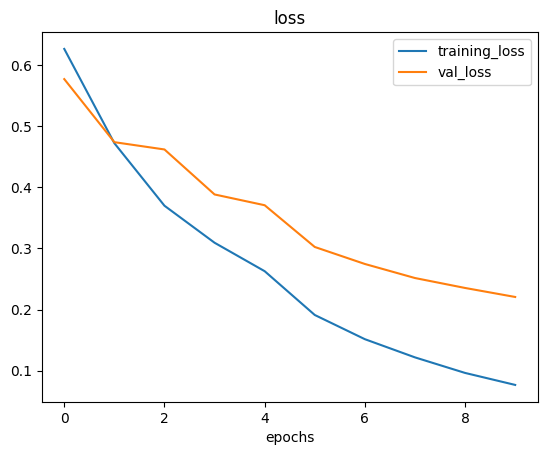

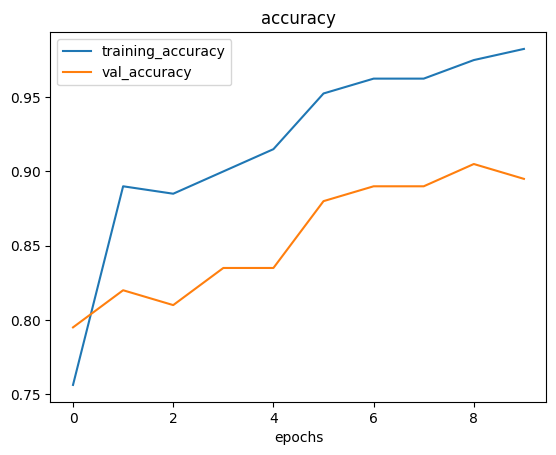

In [ ]:
plot_loss_curves(history1)

**Observation:**

- The highest **accuracy** on validation dataset is **89%**

---
<a name = Section4.1></a>
# **4.2 LSTM Model**
---


In [ ]:
model2=Sequential()
model2.add(Embedding(10000,32, input_length=max_len_text))
model2.add(LSTM(32))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 450, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [ ]:
history2=model2.fit(x_train,train_label,epochs=20,validation_split=0.15,callbacks=[callback])

Epoch 1/20
27/27 [==============================] - 9s 262ms/step - loss: 0.6662 - accuracy: 0.5765 - val_loss: 0.6246 - val_accuracy: 0.4867
Epoch 2/20
27/27 [==============================] - 6s 205ms/step - loss: 0.4592 - accuracy: 0.8400 - val_loss: 0.3669 - val_accuracy: 0.8733
Epoch 3/20
27/27 [==============================] - 8s 284ms/step - loss: 0.2618 - accuracy: 0.9376 - val_loss: 0.2857 - val_accuracy: 0.8867
Epoch 4/20
27/27 [==============================] - 6s 219ms/step - loss: 0.1365 - accuracy: 0.9765 - val_loss: 0.1744 - val_accuracy: 0.9200
Epoch 5/20
27/27 [==============================] - 7s 243ms/step - loss: 0.0711 - accuracy: 0.9835 - val_loss: 0.1659 - val_accuracy: 0.9400
Epoch 6/20
27/27 [==============================] - 5s 202ms/step - loss: 0.0412 - accuracy: 0.9929 - val_loss: 0.1569 - val_accuracy: 0.9533
Epoch 7/20
27/27 [==============================] - 7s 251ms/step - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.1419 - val_accuracy: 0.9467
Epoch 

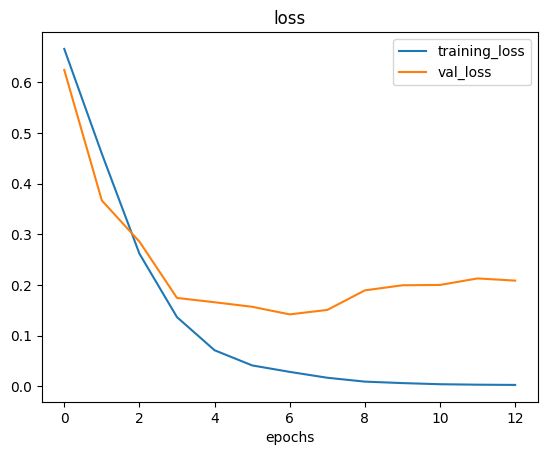

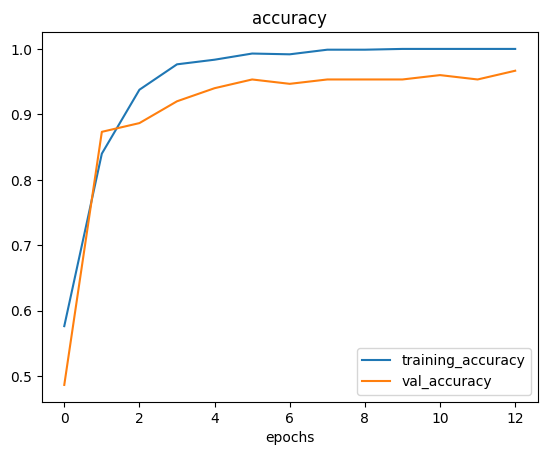

In [ ]:
plot_loss_curves(history2)

**Observation:** 

- The highest **accuracy** on validation dataset is **96%**.

- We can clearly see **LSTM out performs SimpleRNN**.

---
<a name=Section4.3></a>

# **4.3 GRU Model**

---

In [ ]:
model3=Sequential()
model3.add(Embedding(10000,32, input_length=max_len_text))
model3.add(GRU(64))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 450, 32)           320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3=model3.fit(x_train,train_label, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
7/7 [==============================] - 7s 656ms/step - loss: 0.6920 - accuracy: 0.5537 - val_loss: 0.6871 - val_accuracy: 0.7350
Epoch 2/10
7/7 [==============================] - 4s 537ms/step - loss: 0.6800 - accuracy: 0.8763 - val_loss: 0.6753 - val_accuracy: 0.8300
Epoch 3/10
7/7 [==============================] - 5s 633ms/step - loss: 0.6538 - accuracy: 0.8925 - val_loss: 0.6450 - val_accuracy: 0.8250
Epoch 4/10
7/7 [==============================] - 4s 521ms/step - loss: 0.5861 - accuracy: 0.9375 - val_loss: 0.5497 - val_accuracy: 0.8850
Epoch 5/10
7/7 [==============================] - 4s 511ms/step - loss: 0.4291 - accuracy: 0.9100 - val_loss: 0.4049 - val_accuracy: 0.8950
Epoch 6/10
7/7 [==============================] - 5s 713ms/step - loss: 0.2613 - accuracy: 0.9688 - val_loss: 0.2730 - val_accuracy: 0.9150
Epoch 7/10
7/7 [==============================] - 4s 518ms/step - loss: 0.1401 - accuracy: 0.9650 - val_loss: 0.1959 - val_accuracy: 0.9250
Epoch 8/10
7/7 [====

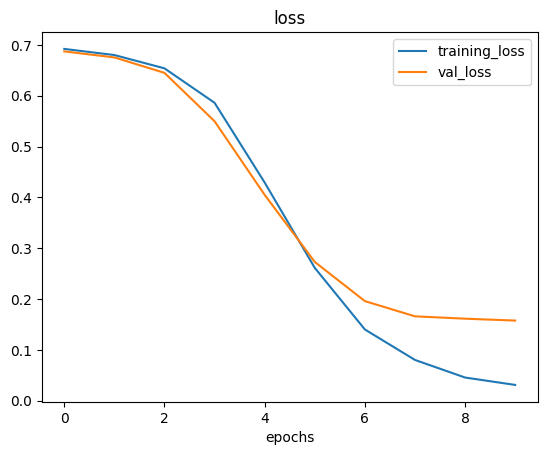

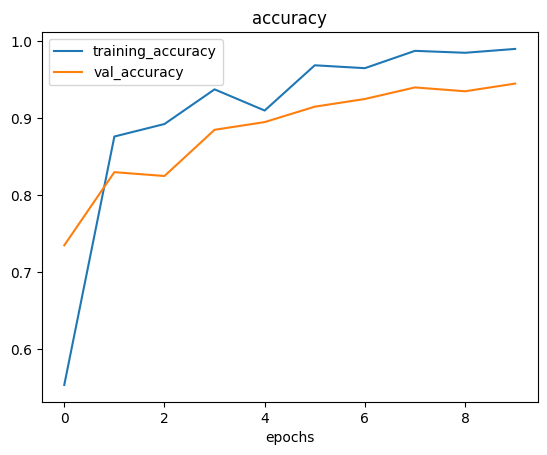

In [ ]:
plot_loss_curves(history3)

**Observations:**

- The highest **accuracy** on validation dataset is **94%**

In [ ]:
accr_rnn=model.evaluate(x_test,test_label)
accr_lstm=model2.evaluate(x_test,test_label)
accr_gru=model3.evaluate(x_test,test_label)

7/7 [==============================] - 0s 40ms/step - loss: 0.1407 - accuracy: 0.9433


In [ ]:
print('RNN on Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_rnn[0],accr_rnn[1]))
print('LSTM on Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_lstm[0],accr_lstm[1]))

print('GRU on Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_gru[0],accr_gru[1]))

RNN on Test set
  Loss: 0.228
  Accuracy: 0.902
LSTM on Test set
  Loss: 0.194
  Accuracy: 0.943
GRU on Test set
  Loss: 0.141
  Accuracy: 0.943


**Obsertvation:** 

- Accuracy of **RNN** have **90%**, **LSTM** have **94%** and **GRU** have **94%** on Testing Dataset.

- We can observe that **LSTM** and **GRU** model performs better than the **simpleRNN** model.

---
<a name =Section5></a>
#**5. Impliment Model on Test Dataset**
---

In [ ]:
df_test=pd.read_excel('/content/spam_test.csv.xlsx')
print(df_test.shape)
print(df_test.head())

(1115, 2)
     Id                                               text
0  3245  Funny fact Nobody teaches volcanoes 2 erupt, t...
1   944  I sent my scores to sophas and i had to do sec...
2  1044  We know someone who you know that fancies you....
3  2484  Only if you promise your getting out as SOON a...
4   812  Congratulations ur awarded either Ã¥Â£500 of C...


- Cleanup on Test Dataset

In [ ]:
df_test['text']=df_test['text'].apply(denoise_text)

In [ ]:
df_test.head()

,Id,text
0,3245,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,944,sent scores sophas secondary application schoo...
2,1044,know someone know fancies you. Call 0905809721...
3,2484,promise getting SOON can. text morning let kno...
4,812,Congratulations ur awarded either Ã¥Â£500 CD g...


In [ ]:
test_tokenizer=Tokenizer(num_words=10000)
test_tokenizer.fit_on_texts(df_test['text'])
test_vector=test_tokenizer.texts_to_sequences(df_test['text'])

In [ ]:
test_df=np.array(vector)

In [ ]:
test_df

array([list([42, 598]),
       list([38, 4, 222, 1883, 136, 1173, 598, 2, 61, 599, 6, 201, 1884, 521, 4, 19, 38, 54, 1885, 335, 1886, 175, 65, 1174]),
       list([123, 1175, 1176, 92, 1887, 1888, 129, 336, 25, 43]), ...,
       list([41, 129, 336, 1664, 255, 108, 392, 1, 2, 416]),
       list([634, 134, 946, 117, 454, 236, 85, 357, 3, 610, 32, 7, 552, 634, 141, 558, 1297, 45, 454, 236]),
       list([4043, 109, 8])], dtype=object)

In [ ]:
test_df=pad_sequences(test_df,maxlen=max_len_text)

- Apply Trained Model on Teasting Dataset

In [ ]:
pred_value=model2.predict(test_df)

38/38 [==============================] - 2s 40ms/step


In [ ]:
sample=pd.DataFrame(data=pred_value,columns=['label'])

In [ ]:
sample.head()

,label
0,0.996425
1,0.001715
2,0.998839
3,0.998068
4,0.997437


In [ ]:
sample['label']=round(sample['label']).astype(int)

In [ ]:
sample.head()

,label
0,1
1,0
2,1
3,1
4,1


In [ ]:
Id=pd.DataFrame(data=df_test.Id)
Id.head()

,Id
0,3245
1,944
2,1044
3,2484
4,812


In [ ]:
final_op=pd.concat([Id,sample],join='outer',axis=1)
final_op.head()

,Id,label
0,3245.0,1
1,944.0,0
2,1044.0,1
3,2484.0,1
4,812.0,1


In [ ]:
final_op.to_csv('/content/Submission.csv')